<a href="https://colab.research.google.com/github/danlingzhou16/stat390/blob/Danling/Danling_390_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima

In [2]:
# libararies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [3]:
train = pd.read_csv('train_final.csv', parse_dates = ['date'], index_col = ['date'])
test = pd.read_csv('test_final.csv', parse_dates = ['date'], index_col = ['date'])

In [5]:
train_sel_for_arima = train[['location_key_x', 'new_confirmed']]
test_sel_for_arima = test[['location_key_x', 'new_confirmed']]

We have a lot of different locations, let's play with US_AK first.

In [6]:
# try the model with one location
AK_train = train_sel_for_arima.loc[train_sel_for_arima.location_key_x == 'US_AK','new_confirmed']
AK_test = test_sel_for_arima.loc[test_sel_for_arima.location_key_x == 'US_AK','new_confirmed']

stationary test

In [7]:
# stationary test
# this code block is adapted from by https://www.kaggle.com/code/sumi25/understand-arima-and-tune-p-d-q
# a fancy way to do the Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 7, cutoff = 0.05):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)

    print(dfoutput)

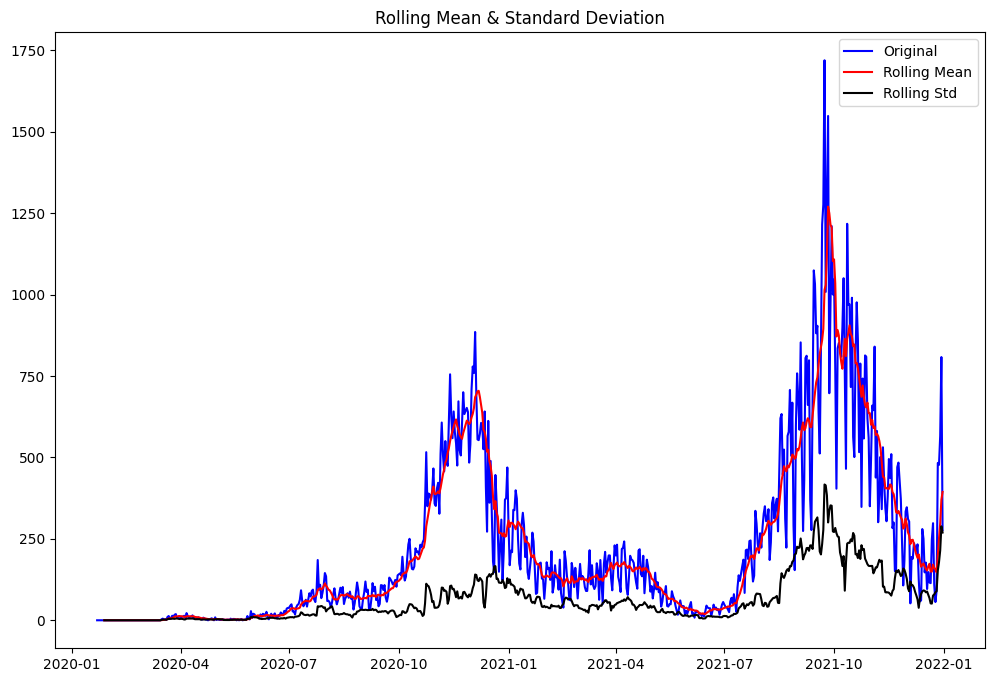

Results of Dickey-Fuller Test:
p-value = 0.3734. The series is likely non-stationary.
Test Statistic                  -1.814328
p-value                          0.373372
#Lags Used                      14.000000
Number of Observations Used    692.000000
Critical Value (1%)             -3.439835
Critical Value (5%)             -2.865726
Critical Value (10%)            -2.568999
dtype: float64


In [8]:
test_stationarity(AK_train)

We will need to tune the p, q, and d. But first, by default, USE p = 1, d = 1, and q = 1 in ARIMA.

In [9]:
# most relevant feature is the data from the day, 3 days and 7 days before
model_AK = ARIMA(AK_train, order = (1,1,1))
model_AK = model_AK.fit()

In [10]:
print(model_AK.summary())

                               SARIMAX Results                                
Dep. Variable:          new_confirmed   No. Observations:                  707
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4272.687
Date:                Thu, 02 Nov 2023   AIC                           8551.375
Time:                        01:18:13   BIC                           8565.053
Sample:                             0   HQIC                          8556.660
                                - 707                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2975      0.033      9.097      0.000       0.233       0.362
ma.L1         -0.8004      0.019    -41.245      0.000      -0.838      -0.762
sigma2      1.056e+04    240.263     43.971      0.0

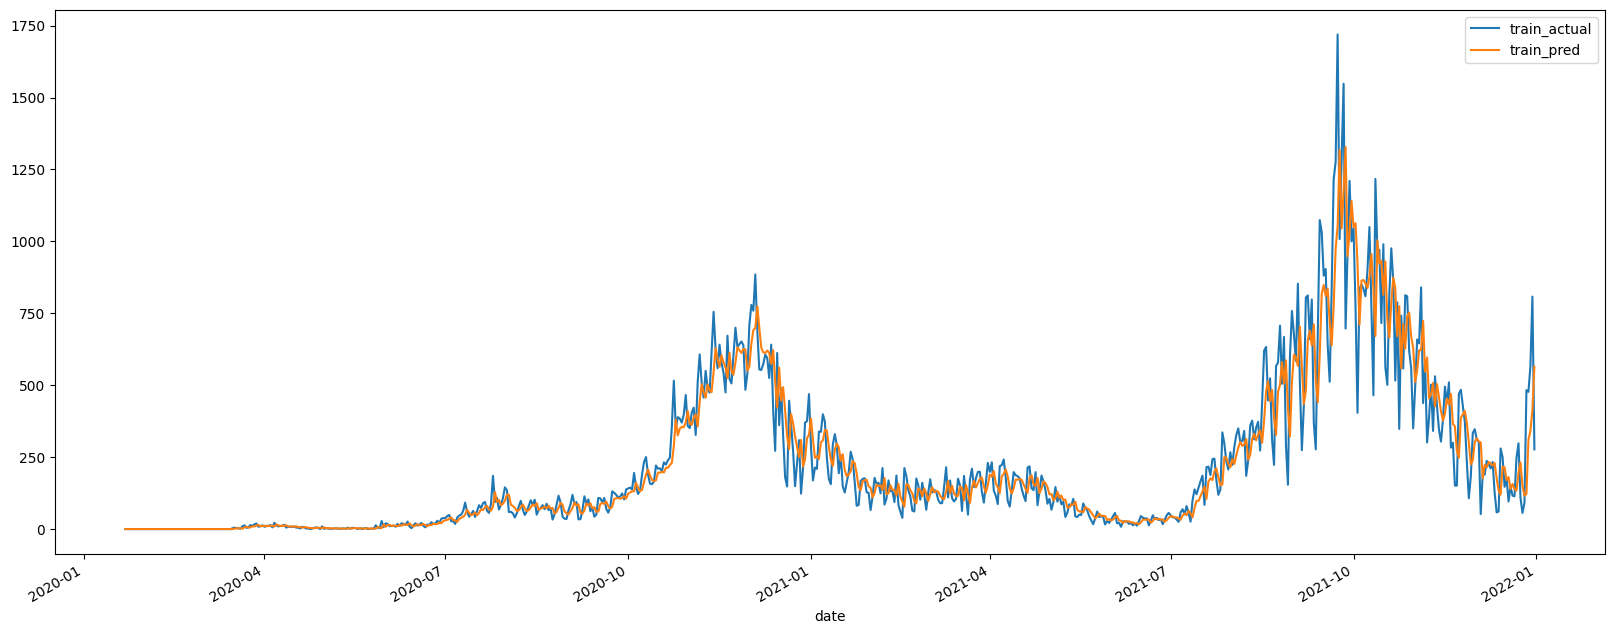

In [11]:
AK_train_pred=model_AK.fittedvalues
pd.concat([AK_train, AK_train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_actual', 'train_pred'])

In [34]:
AK_test_pred = model_AK.predict(start=len(AK_train), end=len(AK_train)+len(AK_test)-1, dynamic=True)
AK_test_pred.index = AK_test.index

In [35]:
AK_test_pred

date
2022-01-01    348.614056
2022-01-02    369.922706
2022-01-03    376.263062
2022-01-04    378.149625
2022-01-05    378.710969
                 ...    
2022-09-11    378.948746
2022-09-12    378.948746
2022-09-13    378.948746
2022-09-14    378.948746
2022-09-15    378.948746
Name: predicted_mean, Length: 258, dtype: float64

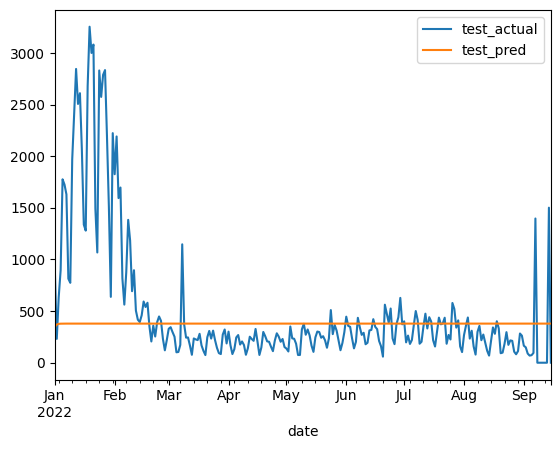

In [36]:
pd.concat([AK_test, AK_test_pred], axis=1).plot()
plt.legend(['test_actual', 'test_pred'])

In [15]:
print('The RMSE of the training data is ', mean_squared_error(AK_train, AK_train_pred, squared=False))
print('The RMSE of the testing data is ', mean_squared_error(AK_test, AK_test_pred, squared=False))

The RMSE of the training data is  102.71063694019013
The RMSE of the testing data is  665.5397049446958


Now, let's tune the p, q, d. Note: here, a cross-validation is not performed because of the amount of computation the whole dataset needs (you will understand what I mean below). Plus, statsmodels, as far as I know, is incompatible with sklearn GS. Instead, I am writing a manual grid search.

Based on our autocorrelation and partial autocorrelation diagram, day (n-1), day(n-3) day (n-7) seem useful lag features. Therefore, p and q will be tried as 1, 3, and 7.

I did not find some comprehensible way to tune d, so I will just follow what this [tutorial](https://www.youtube.com/watch?v=_qv_7lEuiZg) did and set a testing range 0-2. Actually the following code is inspired by this tutorial, but I disagree with the way they validated the model using the testing dataset.

In [55]:
import itertools
p = [1, 3, 7]
q = [1, 3, 7]
d = range(0, 2)
pdq_comb = list(itertools.product(p, d, q))

In [56]:
pdq_comb

[(1, 0, 1),
 (1, 0, 3),
 (1, 0, 7),
 (1, 1, 1),
 (1, 1, 3),
 (1, 1, 7),
 (3, 0, 1),
 (3, 0, 3),
 (3, 0, 7),
 (3, 1, 1),
 (3, 1, 3),
 (3, 1, 7),
 (7, 0, 1),
 (7, 0, 3),
 (7, 0, 7),
 (7, 1, 1),
 (7, 1, 3),
 (7, 1, 7)]

In [57]:
rmse = []
order1 = []
for pdq in pdq_comb:
  try:
    model = ARIMA(AK_train, order = pdq).fit()
    train_fitted = model.fittedvalues
    error = mean_squared_error(AK_train, train_fitted, squared = False)
    order1.append(pdq)
    rmse.append(error)
  except:
    continue

In [58]:
results = pd.DataFrame(index = order1, data = rmse, columns = ['rmse'])
results.reset_index(inplace = True)
results.sort_values(by = 'rmse', ascending = True).iloc[0,0]

(7, 1, 7)

There fore p = 7, d = 1 and q = 7 produces the best-fit model for the training dataset.

In [59]:
model_AK2 = ARIMA(AK_train, order = (7,1,7)).fit()
print(model_AK2.summary())

                               SARIMAX Results                                
Dep. Variable:          new_confirmed   No. Observations:                  707
Model:                 ARIMA(7, 1, 7)   Log Likelihood               -4169.151
Date:                Thu, 02 Nov 2023   AIC                           8368.302
Time:                        01:38:10   BIC                           8436.696
Sample:                             0   HQIC                          8394.730
                                - 707                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6844      0.129     -5.318      0.000      -0.937      -0.432
ar.L2         -0.9586      0.074    -12.934      0.000      -1.104      -0.813
ar.L3         -0.8438      0.091     -9.227      0.0

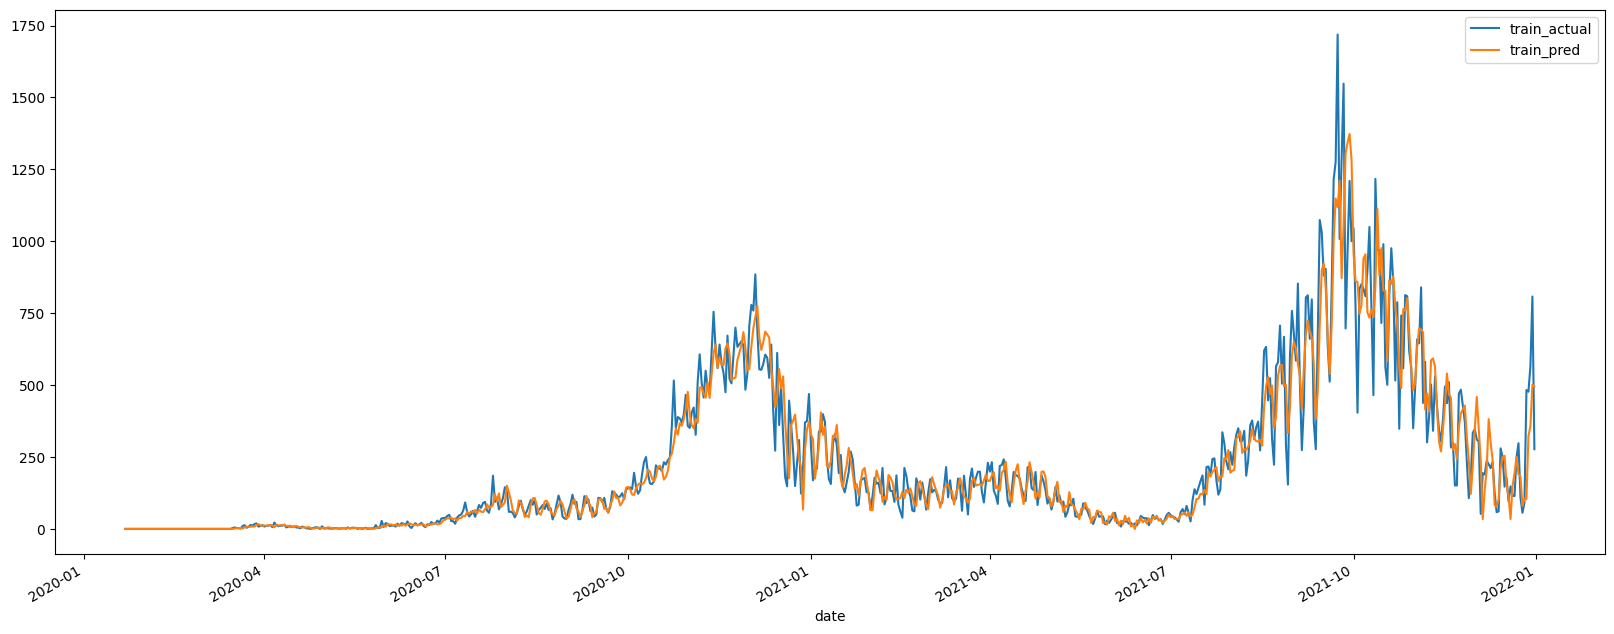

In [60]:
AK_train_pred2=model_AK2.fittedvalues
pd.concat([AK_train, AK_train_pred2], axis=1).plot(figsize=(20, 8))
plt.legend(['train_actual', 'train_pred'])

In [61]:
AK_test_pred2 = model_AK2.predict(start=len(AK_train), end=len(AK_train)+len(AK_test)-1, dynamic=True)
AK_test_pred2.index = AK_test.index
AK_test_pred2

date
2022-01-01    329.492137
2022-01-02    353.964417
2022-01-03    445.679642
2022-01-04    534.555572
2022-01-05    589.668561
                 ...    
2022-09-11    464.457985
2022-09-12    475.366633
2022-09-13    478.194656
2022-09-14    470.965585
2022-09-15    459.313161
Name: predicted_mean, Length: 258, dtype: float64

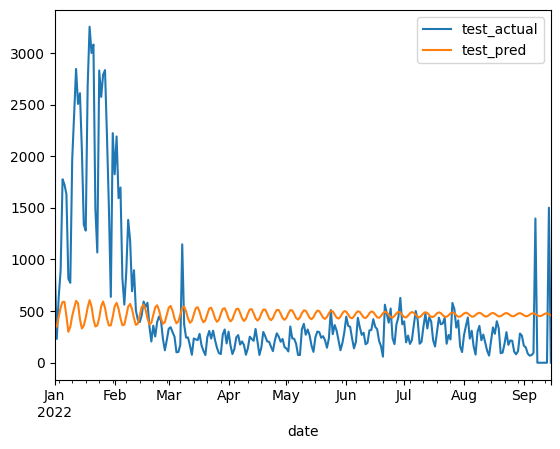

In [62]:
pd.concat([AK_test, AK_test_pred2], axis=1).plot()
plt.legend(['test_actual', 'test_pred'])

In [63]:
print('The RMSE of the training data is ', mean_squared_error(AK_train, AK_train_pred2, squared=False))
print('The RMSE of the testing data is ', mean_squared_error(AK_test, AK_test_pred2, squared=False))

The RMSE of the training data is  88.41219726460349
The RMSE of the testing data is  644.284092953681


The accuracy on training and testing data improved as tuning of the ARIMA model. However, this model failed to capture the peaks in 2022.

Now, the model needs to be expanded to the whole dataset, but this will be computationally expensive because we have so many locations...

In [67]:
train_sel_for_arima.location_key_x.nunique()

102

Let's see if this 7, 1, 7 combination works the best for a sample of these locations.

In [79]:
import random
loc_list = list(train_sel_for_arima.location_key_x.unique())
a_random_sample = random.sample(loc_list, 20)
a_random_sample

['CH_BS',
 'US_PA',
 'NO_46',
 'US_NC',
 'CH_VD',
 'CH_GE',
 'NO_11',
 'US_MN',
 'NO_03',
 'AU_WA',
 'CH_AR',
 'CH_SH',
 'AU_NT',
 'CH_NE',
 'US_IN',
 'US_FL',
 'US_CO',
 'NO_50',
 'CH_TG',
 'US_ME']

In [80]:
for loc in a_random_sample:
  train_interest = train_sel_for_arima.loc[train_sel_for_arima.location_key_x == loc, 'new_confirmed'] # select the rows in the training data
  rmse = []
  order1 = []
  for pdq in pdq_comb:
    try:
      model = ARIMA(train_interest, order = pdq).fit()
      train_fitted = model.fittedvalues
      error = mean_squared_error(train_interest, train_fitted, squared = False)
      order1.append(pdq)
      rmse.append(error)
    except:
      continue
  results = pd.DataFrame(index = order1, data = rmse, columns = ['rmse'])
  results.reset_index(inplace = True)
  print(loc, results.sort_values(by = 'rmse', ascending = True).iloc[0,0])

CH_BS (7, 1, 7)
US_PA (7, 1, 7)
NO_46 (7, 1, 7)
US_NC (7, 1, 7)
CH_VD (7, 1, 7)
CH_GE (7, 1, 7)
NO_11 (7, 1, 7)
US_MN (7, 0, 7)
NO_03 (7, 1, 7)
AU_WA (7, 0, 7)
CH_AR (7, 1, 7)
CH_SH (7, 1, 7)
AU_NT (7, 1, 7)
CH_NE (7, 1, 7)
US_IN (7, 1, 7)
US_FL (7, 1, 7)
US_CO (7, 1, 7)
NO_50 (7, 1, 7)
CH_TG (7, 1, 7)
US_ME (7, 0, 7)


Interesting results! p and q seem to take only 7, but d can be 0 and 1. There is a need to scan through every region in this dataset. However, the grid can be simplified a bit.

In [81]:
p = [1, 7]
q = [1, 7] # From the autocorrelation, n-3 is not very interesting anyway
d = range(0, 2)
pdq_comb_simplified = list(itertools.product(p, d, q))

In [98]:
# making a pred_train and pred_test dataset
train_pred = train_sel_for_arima.copy()
train_pred.new_confirmed = None
train_pred.columns = ['location_key_x','prediected_new_confirmed']
train_pred.reset_index(inplace = True)
test_pred = test_sel_for_arima.copy()
test_pred.new_confirmed = None
test_pred.columns = ['location_key_x','prediected_new_confirmed']
test_pred.reset_index(inplace = True)

In [101]:
train_pred

,date,location_key_x,prediected_new_confirmed
0,2020-01-22,US_AK,None
1,2020-01-23,US_AK,None
2,2020-01-24,US_AK,None
3,2020-01-25,US_AK,None
4,2020-01-26,US_AK,None
...,...,...,...
69908,2021-12-27,AU_WA,None
69909,2021-12-28,AU_WA,None
69910,2021-12-29,AU_WA,None
69911,2021-12-30,AU_WA,None


In [103]:
loc_list = list(train_sel_for_arima.location_key_x.unique())
for loc in loc_list:
  # to find the best pdq
  train_interest = train_sel_for_arima.loc[train_sel_for_arima.location_key_x == loc, 'new_confirmed'] # select the rows in the training data
  test_interest = test_sel_for_arima.loc[test_sel_for_arima.location_key_x == loc, 'new_confirmed'] # select the rows in the testing data
  rmse = []
  order1 = []
  for pdq in pdq_comb_simplified:
    try:
      model = ARIMA(train_interest, order = pdq).fit()
      train_fitted = model.fittedvalues
      error = mean_squared_error(train_interest, train_fitted, squared = False)
      order1.append(pdq)
      rmse.append(error)
    except:
      continue
  results = pd.DataFrame(index = order1, data = rmse, columns = ['rmse'])
  results.reset_index(inplace = True)
  pdq_slct = results.sort_values(by = 'rmse', ascending = True).iloc[0,0]
  # fit the model on the train dataset
  model = ARIMA(train_interest, order = pdq_slct).fit()
  pred_for_train = model.fittedvalues
  for date in pred_for_train.index:
    train_pred.loc[(train_pred.location_key_x == loc) & (train_pred.date == date), 'prediected_new_confirmed'] = pred_for_train[date]
  # predict test dataset
  pred_for_test = model.predict(start=len(train_interest), end=len(train_interest)+len(test_interest)-1, dynamic=True)
  pred_for_test.index = test_interest.index
  for date in pred_for_test.index:
    test_pred.loc[(test_pred.location_key_x == loc) & (test_pred.date == date), 'prediected_new_confirmed'] = pred_for_test[date]


In [104]:
test_pred

,date,location_key_x,prediected_new_confirmed
0,2022-01-01,US_AK,329.492137
1,2022-01-02,US_AK,353.964417
2,2022-01-03,US_AK,445.679642
3,2022-01-04,US_AK,534.555572
4,2022-01-05,US_AK,589.668561
...,...,...,...
26217,2022-09-14,AU_WA,1.761884
26218,2022-09-15,AU_WA,1.761884
26219,2022-09-16,AU_WA,1.761884
26220,2022-09-23,AU_WA,1.761884


In [106]:
print("the rmse on the training data is ", mean_squared_error(train_sel_for_arima.new_confirmed, train_pred.prediected_new_confirmed, squared = False))
print("the rmse on the testing data is ", mean_squared_error(test_sel_for_arima.new_confirmed, test_pred.prediected_new_confirmed, squared = False))

the rmse on the training data is  1102.894026450669
the rmse on the testing data is  99533.83232511982


It is interesting to note that some regions have very large rmse. Let's try to break it down further and see which reagion is causing the problem...

In [153]:
rmse_table = pd.DataFrame(columns = ['region','train_rmse','test_rmse'])
rmse_table.region = loc_list
for loc in loc_list:
   pred_interest = train_pred.loc[train_pred.location_key_x == loc, 'prediected_new_confirmed']
   actual_interest = train_sel_for_arima.loc[train_sel_for_arima.location_key_x == loc, 'new_confirmed']
   rmse_train = mean_squared_error(actual_interest, pred_interest, squared = False)
   rmse_table.loc[rmse_table.region == loc, 'train_rmse'] = rmse_train
   pred_test_interest = test_pred.loc[test_pred.location_key_x == loc, 'prediected_new_confirmed']
   actual_test_interest = test_sel_for_arima.loc[test_sel_for_arima.location_key_x == loc, 'new_confirmed']
   rmse_test = mean_squared_error(actual_test_interest, pred_test_interest, squared = False)
   rmse_table.loc[rmse_table.region == loc, 'test_rmse'] = rmse_test

In [154]:
rmse_table.sort_values(by = 'train_rmse', ascending = False)

,region,train_rmse,test_rmse
10,US_FL,5116.986079,568116.750374
47,US_TX,4565.681807,18210.557781
5,US_CA,4195.457469,69040.767617
37,US_NY,2506.8649,794048.569404
24,US_MI,2316.522251,13047.839707
...,...,...,...
90,CH_UR,5.283291,59.197786
70,CH_AI,3.731276,22.129363
101,AU_WA,2.611447,5884.991315
99,AU_NT,2.05907,554.426868


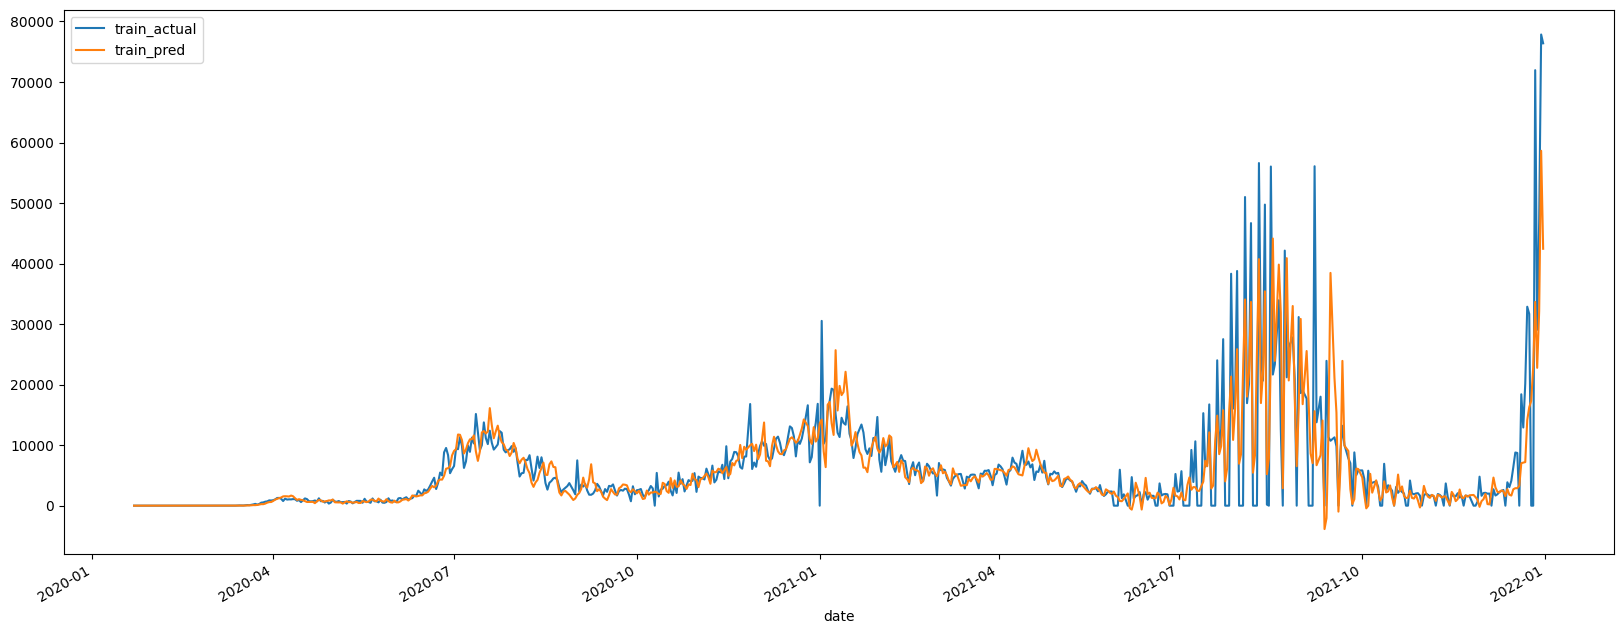

In [145]:
train_pred_date_index = train_pred.copy()
train_pred_date_index.index = train_pred_date_index.date
pd.merge(left = train_sel_for_arima.loc[train_sel_for_arima.location_key_x == 'US_FL', 'new_confirmed'], right = train_pred_date_index.loc[train_pred_date_index.location_key_x == 'US_FL', 'prediected_new_confirmed'], left_index=True, right_index=True).plot(figsize=(20, 8))
plt.legend(['train_actual', 'train_pred'])

Okay, this is just because much more people in FL get COVID (i.e., FL has more population). Probably we can explore with population as well.



In [173]:
pop_rmse_table = rmse_table.merge(train[['location_key_x','population']], how = 'left', left_on = 'region', right_on = 'location_key_x').drop_duplicates()

In [174]:
pop_rmse_table

,region,train_rmse,test_rmse,location_key_x,population
0,US_AK,88.412197,644.284093,US_AK,733391.0
707,US_AL,832.216914,8875.619267,US_AL,5024279.0
1414,US_AR,420.628416,3081.92145,US_AR,3011524.0
2118,US_AS,0.209103,134.306656,US_AS,49710.0
2827,US_AZ,1017.728499,6350.319637,US_AZ,7151502.0
...,...,...,...,...,...
66448,IS,26.684066,19144.131057,IS,356991.0
67179,DK,472.689971,58011.477218,DK,5806081.0
67892,AU_NT,2.05907,554.426868,AU_NT,245353.0
68568,AU_SA,19.279182,36892.53492,AU_SA,1767247.0


In [175]:
pop_rmse_table['train_rmse_over_pop'] = pop_rmse_table.train_rmse/pop_rmse_table.population
pop_rmse_table['test_rmse_over_pop'] = pop_rmse_table.test_rmse/pop_rmse_table.population
pop_rmse_table = pd.melt(pop_rmse_table, id_vars = 'region', value_vars = ['train_rmse_over_pop', 'test_rmse_over_pop'])
pop_rmse_table

,region,variable,value
0,US_AK,train_rmse_over_pop,0.000121
1,US_AL,train_rmse_over_pop,0.000166
2,US_AR,train_rmse_over_pop,0.00014
3,US_AS,train_rmse_over_pop,0.000004
4,US_AZ,train_rmse_over_pop,0.000142
...,...,...,...
199,IS,test_rmse_over_pop,0.053626
200,DK,test_rmse_over_pop,0.009992
201,AU_NT,test_rmse_over_pop,0.00226
202,AU_SA,test_rmse_over_pop,0.020876


<Axes: xlabel='region', ylabel='value'>

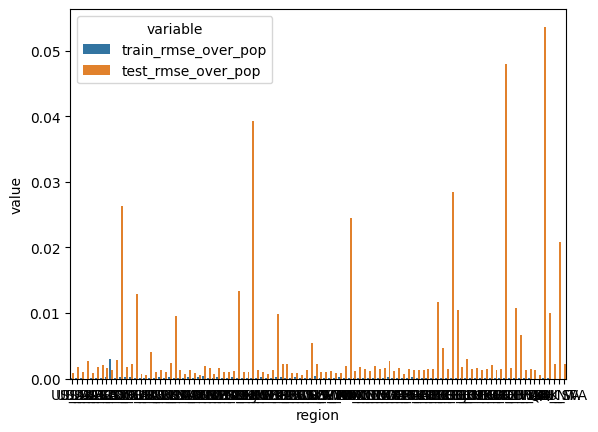

In [178]:
sns.barplot(x = 'region', y = 'value', hue = 'variable', data = pop_rmse_table)